# Augmented VAE training

In [1]:
%load_ext autoreload
%autoreload 2

import os


os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
# XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.98"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.pgm_mnist import get_config as get_pgm_config
from experiments.configs.vae_mnist import get_config as get_vae_config
from src.utils.input import get_data
from src.models.aug_vae import AUG_VAE, create_aug_vae_state, make_aug_vae_train_and_eval, make_aug_vae_plotting_fns
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.models.transform_generative_model import TransformationGenerativeNet, create_transformation_generative_state, make_transformation_generative_train_and_eval
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.utils.training import custom_wandb_logger

TRAIN_PGM = True


/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0000 00:00:1697151343.824478  318004 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
ANGLE = 180
pgm_config = get_pgm_config(f"{ANGLE}")
vae_config = get_vae_config(f"{ANGLE}")

In [3]:
rng = random.PRNGKey(pgm_config.seed)
data_rng, inf_init_rng, gen_init_rng, vae_init_rng, inf_state_rng, gen_state_rng, vae_state_rng = random.split(rng, 7)

## Get data

In [4]:
train_ds, val_ds, _ = get_data(pgm_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

In [5]:
# # get an example from the validation data 
# example = next(deterministic_data.start_input_pipeline(val_ds))['image'][0][14]

# plt.imshow(example, cmap='gray')
# plt.axis('off')
# plt.show()

# # now lets apply 4 random rotations to this image
# # and plot the results
# rotations = [50, 90, 110, 150, 180, 230, 300, 345, 1]
# for rot in rotations:
#     transformed = transform_image(example, jnp.array([0, 0, (rot - 90) * jnp.pi / 180, 0, 0]))
#     plt.imshow(rescale_for_imshow(transformed), cmap='gray')
#     plt.axis('off')
#     # save with same border as in plt.show
#     plt.savefig(f"rot_{rot}.png", bbox_inches='tight', pad_inches=0)
#     plt.show()

## Train Inference Net

In [6]:
inf_model = TransformationInferenceNet(**pgm_config.model.inference.to_dict())

variables = inf_model.init({'params': inf_init_rng, 'sample': inf_init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+--------------------------+-------------+---------+-----------+--------+
| Name                     | Shape       | Size    | Mean      | Std    |
+--------------------------+-------------+---------+-----------+--------+
| params/Dense_0/bias      | (1024,)     | 1,024   | 0.0       | 0.0    |
| params/Dense_0/kernel    | (784, 1024) | 802,816 | -5.95e-05 | 0.0357 |
| params/Dense_1/bias      | (512,)      | 512     | 0.0       | 0.0    |
| params/Dense_1/kernel    | (1024, 512) | 524,288 | -2.79e-05 | 0.0313 |
| params/Dense_2/bias      | (256,)      | 256     | 0.0       | 0.0    |
| params/Dense_2/kernel    | (512, 256)  | 131,072 | 4.69e-05  | 0.0441 |
| params/Dense_3/bias      | (128,)      | 128     | 0.0       | 0.0    |
| params/Dense_3/kernel    | (256, 128)  | 32,768  | -3.69e-05 | 0.0626 |
| params/Dense_4/bias      | (5,)        | 5       | 0.0       | 0.0    |
| params/Dense_4/kernel    | (128, 5)    | 640     | 0.0       | 0.0    |
| params/LayerNorm_0/bias  

In [7]:
params = flax.core.freeze(variables["params"])
del variables

inf_state = create_transformation_inference_state(params, inf_state_rng, pgm_config)

train_step, eval_step = make_transformation_inference_train_and_eval(inf_model, pgm_config)

INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.
INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.
INFO:absl:A polynomial schedule was set with a non-positive `transition_steps` value; this results in a constant schedule with value `init_value`.


In [8]:
if TRAIN_PGM:
    final_inf_state, history, _ = ciclo.train_loop(
        inf_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [
                train_step
            ],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
            # ciclo.every(1): custom_wandb_logger(run=run)
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(pgm_config.inf_steps * pgm_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=pgm_config.inf_steps),
            # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
            # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
        ],
        stop=pgm_config.inf_steps + 1,
    )

    fig = plot_proto_model_training_metrics(history)

    # save the final_pgm_state
    checkpoints.save_checkpoint("inf_model", final_inf_state, final_inf_state.step, overwrite=True)
else:
    final_inf_state = checkpoints.restore_checkpoint("inf_model", inf_state)

10000/10000 [==============================] - 397s 40ms/step - invertibility_loss: 0.1070 - loss: 0.0633 - x_mse: 0.0633 - η_recon_loss: 0.1502 - invertibility_loss_test: 0.1070 - loss_test: 0.0642 - x_mse_test: 0.0642 - η_recon_loss_test: 0.1486 - label_paired_image_mse_test: 0.3625  - ETA: 8:59:28 - invertibility_loss: 0.1598 - loss: 0.4690 - x_mse: 0.4690 - η_recon_loss: 0.5811 - invertibility_loss_test: 0.1601 - loss_test: 0.4513 - x_mse_test: 0.4513 - η_recon_loss_test - ETA: 38:50 - invertibility_loss: 0.1354 - loss: 0.2711 - x_mse: 0.2711 - η_recon_loss: 0.4587 - invertibility_loss_test: 0.1350 - loss_test: 0.2719 - x_mse_test: 0.2719 - η_recon_loss_test: 0.4587 - label_paired_image_mse_test: 0.410 - ETA: 38:14 - invertibility_loss: 0.1355 - loss: 0.2703 - x_mse: 0.2703 - η_recon_loss: 0.4587 - invertibility_loss_test: 0.1350 - loss_test: 0.2719 - x_mse_test: 0.2719 - η_recon_loss_test: 0.4587 - label_pa - ETA: 26:43 - invertibility_loss: 0.1337 - loss: 0.2527 - x_mse: 0.2527 -

INFO:absl:Saving checkpoint at step: 10001
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:OCDBT is initialized successfully.
INFO:absl:Saving item to inf_model/checkpoint_10001.
INFO:absl:Specified `force`: removing existing directory.
INFO:absl:Renaming inf_model/checkpoint_10001.orbax-checkpoint-tmp-1697151756491644 to inf_model/checkpoint_10001
INFO:absl:Finished saving checkpoint to `inf_model/checkpoint_10001`.


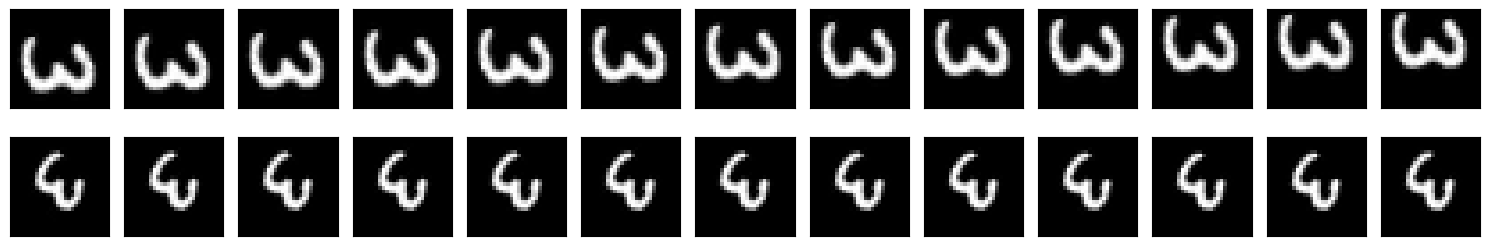

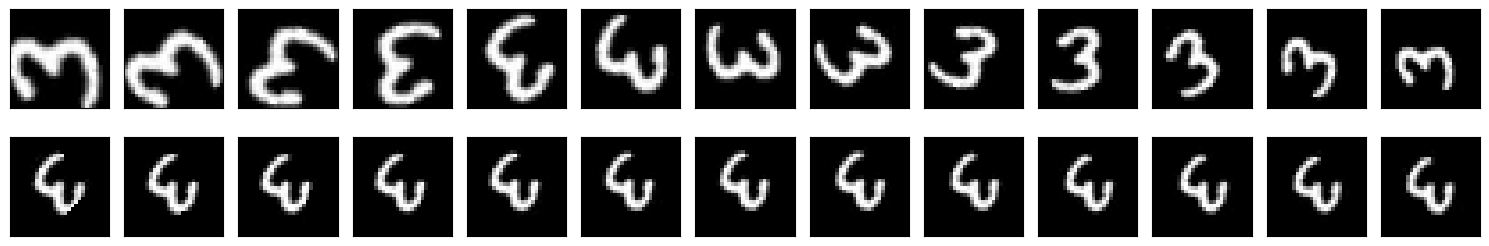

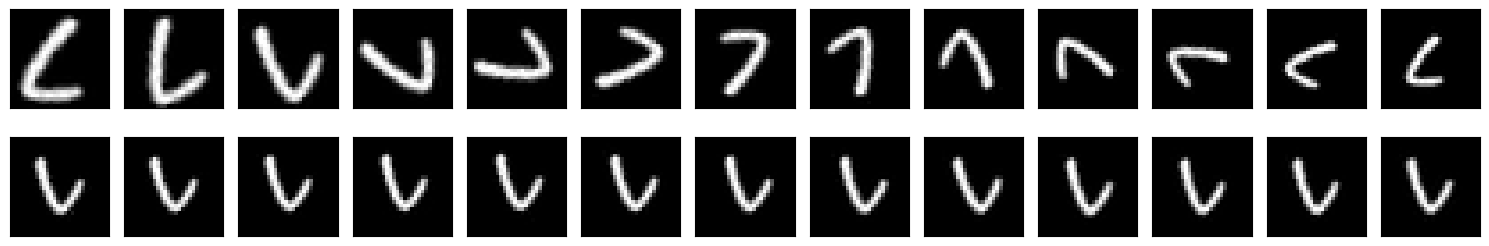

In [9]:
from src.transformations.affine import gen_affine_matrix_no_shear, transform_image_with_affine_matrix

val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

@jax.jit
def get_prototype(x):
    q_Η_x = inf_model.apply({"params": final_inf_state.params}, x, train=False)
    η = q_Η_x.sample(seed=rng)
    affine_matrix = gen_affine_matrix_no_shear(η)
    affine_matrix_inv = jnp.linalg.inv(affine_matrix)
    xhat = transform_image_with_affine_matrix(x, affine_matrix_inv, order=pgm_config.interpolation_order)
    return xhat, η

for x_ in [
    val_batch['image'][0][14],
    val_batch['image'][0][12],
]:
    for mask in [
        # jnp.array([0, 0, 1, 0, 0]),
        jnp.array([0, 1, 0, 0, 0]),
        jnp.array([1, 1, 0, 0, 0]),
        # jnp.array([0, 0, 0, 1, 1]),
        jnp.array([1, 1, 1, 1, 1])
    ]:

        transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
            x_,
            jnp.linspace(-jnp.array(pgm_config.augment_bounds[:5]) * mask, jnp.array(pgm_config.augment_bounds[:5]) * mask, 13)
        )

        xhats, ηs = jax.vmap(get_prototype)(transformed_xs)

        fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

        for ax, x in zip(axs[0], list(transformed_xs)):
            ax.imshow(rescale_for_imshow(x), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, xhat in zip(axs[1], list(xhats)):
            ax.imshow(rescale_for_imshow(xhat), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

## Train Generative Net

In [10]:
def prototype_function(x, rng):
    η = inf_model.apply({"params": final_inf_state.params}, x, train=False).sample(seed=rng)
    return η

In [11]:
gen_model = TransformationGenerativeNet(**pgm_config.model.generative.to_dict())

variables = gen_model.init({'params': gen_init_rng, 'sample': gen_init_rng}, jnp.empty((28, 28, 1)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+-------------------------------------+-------------+---------+-----------+--------+
| Name                                | Shape       | Size    | Mean      | Std    |
+-------------------------------------+-------------+---------+-----------+--------+
| params/Conditioner_0/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_0/Dense_0/kernel | (256, 256)  | 65,536  | -6.21e-05 | 0.0624 |
| params/Conditioner_0/Dense_1/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_0/Dense_1/kernel | (256, 256)  | 65,536  | 0.000151  | 0.0624 |
| params/Conditioner_0/Dense_2/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/Conditioner_0/Dense_2/kernel | (256, 65)   | 16,640  | 0.0       | 0.0    |
| params/Conditioner_1/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_1/Dense_0/kernel | (256, 256)  | 65,536  | 0.000186  | 0.0626 |
| params/Conditioner_1/Dense_1/bias   | (256,)      | 

In [12]:
gen_params = flax.core.freeze(variables["params"])

gen_state = create_transformation_generative_state(gen_params, gen_state_rng, pgm_config)

train_step, eval_step = make_transformation_generative_train_and_eval(gen_model, pgm_config, prototype_function=prototype_function)

In [13]:
if TRAIN_PGM:
    final_gen_state, history, _ = ciclo.train_loop(
        gen_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [
                train_step
            ],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
            # ciclo.every(1): custom_wandb_logger(run=run)
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(pgm_config.gen_steps * pgm_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=pgm_config.gen_steps),
            # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
            # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
        ],
        stop=pgm_config.gen_steps + 1,
    )

    import seaborn as sns
    colors = sns.color_palette("husl", 3)

    # plot the training history
    steps, loss, log_p_η_x_hat, mae, lr_gen,  = history.collect(
        "steps",
        "loss",
        "log_p_η_x_hat",
        "mae",
        "lr_gen"
    )
    mae_loss_mult = history.collect("mae_loss_mult")
    steps_test, loss_test, log_p_η_x_hat_test, mae_test = history.collect(
        "steps", "loss_test", "log_p_η_x_hat_test", "mae_test"
    )

    n_plots = 4
    fig, axs = plt.subplots(
        n_plots, 1, figsize=(15, n_plots * 3.0), dpi=300, sharex=True
    )

    for train_metric, test_metric, metric_name, ax in zip(
        [loss, log_p_η_x_hat, mae],
        [loss_test, log_p_η_x_hat_test, mae_test],
        ["loss", "log_p_η_x_hat", "mae"],
        axs,
    ):
        ax.plot(steps, train_metric, label=f"train {train_metric[-1]:.4f}", color=colors[0])
        ax.plot(steps_test, test_metric, label=f"test  {test_metric[-1]:.4f}", color=colors[1])
        ax.legend()
        ax.set_title(metric_name)

    # Schedule axis:
    host = axs[-1]
    par1 = host.twinx()
    # par2 = host.twinx()

    p1, = host.plot(steps, lr_gen, "--", label=f"gen   {lr_gen[-1]:.4f}", color=colors[0])
    p2, = par1.plot(
        steps,
        mae_loss_mult,
        label=f"mae_loss_mult {mae_loss_mult[-1]:.4f}",
        color=colors[2]
    )
    lines = [p1, p2]
    host.legend(lines, [l.get_label() for l in lines])

    host.set_yscale("log")
    par1.set_yscale("log")
    # par2.set_yscale("log")

    host.set_ylabel(f"LR")
    # par1.set_ylabel("σ LR")
    par1.set_ylabel("Multipliers")

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    # par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    # par2.tick_params(axis='y', colors=p3.get_color(), **tkw)

    axs[-1].set_xlim(min(steps), max(steps))
    axs[-1].set_xlabel("Steps")

    for ax in axs:
        ax.grid(color=(0.9, 0.9, 0.9))

    plt.show()

    checkpoints.save_checkpoint("gen_model", final_gen_state, final_gen_state.step, overwrite=True)
else:
    final_gen_state = checkpoints.restore_checkpoint("gen_model", gen_state)

10000/10000 [==============================] - 214s 21ms/step - log_p_η_x_hat: 5.1862 - loss: -4.5608 - mae: 0.6285 - log_p_η_x_hat_test: 3.9722 - loss_test: -3.2316 - mae_test: 0.7406


INFO:absl:Saving checkpoint at step: 10001
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to gen_model/checkpoint_10001.
INFO:absl:Specified `force`: removing existing directory.
INFO:absl:Renaming gen_model/checkpoint_10001.orbax-checkpoint-tmp-1697151989723041 to gen_model/checkpoint_10001
INFO:absl:Finished saving checkpoint to `gen_model/checkpoint_10001`.


In [14]:
from scipy.stats import gaussian_kde


# function to plot the histograms of p(η|x_hat) in each dimmension
def plot_hists(x, n=10_000):
    # q_H_x = q_H_X.apply(q_H_X_vars, x)
    # ηs_q = canon_functini(seed=random.PRNGKey(0), sample_shape=(n))
    # η = ηs_q[jnp.argmax(log_probs)]
    # TODO: is the argmaxing here necessary? Why not do it in the canon_function?
    η = prototype_function(x, rng)
    η_aff_mat = gen_affine_matrix_no_shear(η)
    η_aff_mat_inv = jnp.linalg.inv(η_aff_mat)
    xhat = transform_image_with_affine_matrix(x, η_aff_mat_inv, order=pgm_config.interpolation_order)

    p_H_x_hat = gen_model.apply({"params": final_gen_state.params}, xhat)
    
    ηs_p = p_H_x_hat.sample(seed=random.PRNGKey(0), sample_shape=(10_000,))

    D = p_H_x_hat.event_shape[0]
    fig, axs = plt.subplots(1, D + 2, figsize=(3*(D+2), 3))

    axs[0].imshow(rescale_for_imshow(x), cmap='gray')
    axs[1].imshow(rescale_for_imshow(xhat), cmap='gray')

    for i, ax in enumerate(axs[2:]):
        x = np.linspace(pgm_config.augment_bounds[i] - 1e-5, -pgm_config.augment_bounds[i] + 1e-5, 1000)

        # plot p(η|x_hat)
        ax.hist(ηs_p[:, i], bins=100, density=True, alpha=0.5, color="C0")
        kde = gaussian_kde(ηs_p[:, i])
        ax.plot(x, kde(x), color="C0")

        # make a axvline to plot η, make the line dashed
        ax.axvline(η[i], color="C1", linestyle="--")
        # make a twin axis to plot q(η|x)
        # ax2 = ax.twinx()
        # ax2.hist(ηs_q[:, i], bins=100, density=True, alpha=0.5, color="C1")
        # kde = gaussian_kde(ηs_q[:, i])
        # ax2.plot(x, kde(x), color="C1")

        ax.set_title(f"dim {i}")
        ax.set_xlim(-2 * pgm_config.augment_bounds[i], 2 * pgm_config.augment_bounds[i])

    plt.tight_layout()
    plt.show()

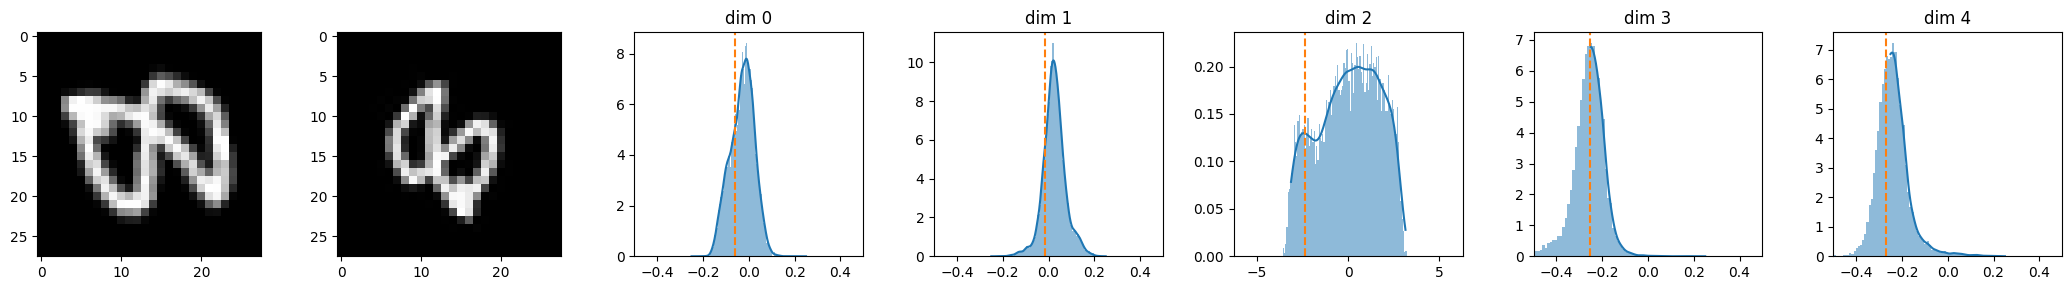

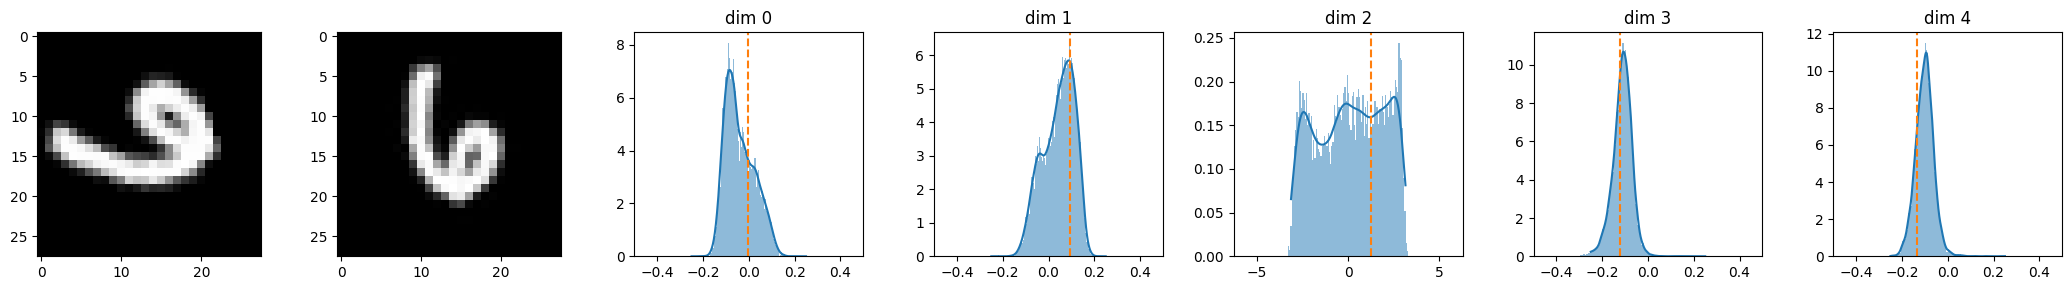

In [15]:
plot_hists(val_batch['image'][0][14], n=1_000)
plot_hists(val_batch['image'][0][1], n=1_000)
plot_hists(val_batch['image'][0][4], n=1_000)
plot_hists(val_batch['image'][0][9], n=1_000)

## Train AUG-VAE

In [16]:
from src.models.aug_vae import AUG_VAE

In [17]:
train_ds, val_ds, _ = get_data(vae_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}


INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest

In [18]:
aug_vae_model = AUG_VAE(
    vae=vae_config.model.to_dict(),
    inference=pgm_config.model.inference.to_dict(),
    generative=pgm_config.model.generative.to_dict(),
    interpolation_order=pgm_config.interpolation_order,
)

variables = aug_vae_model.init({'params': vae_init_rng, 'sample': vae_init_rng}, jnp.empty((28, 28, 1)), train=True)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+------------------------------------------------------+------------------+---------+-----------+----------+
| Name                                                 | Shape            | Size    | Mean      | Std      |
+------------------------------------------------------+------------------+---------+-----------+----------+
| params/generative_model/Conditioner_0/Dense_0/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/generative_model/Conditioner_0/Dense_0/kernel | (256, 256)       | 65,536  | 5.32e-05  | 0.0624   |
| params/generative_model/Conditioner_0/Dense_1/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/generative_model/Conditioner_0/Dense_1/kernel | (256, 256)       | 65,536  | -7.67e-05 | 0.0626   |
| params/generative_model/Conditioner_0/Dense_2/bias   | (65,)            | 65      | 0.0       | 0.0      |
| params/generative_model/Conditioner_0/Dense_2/kernel | (256, 65)        | 16,640  | 0.0       | 0.0      |
| params

In [19]:
params = variables["params"]
# final_inf_state = checkpoints.restore_checkpoint("inf_model", inf_state)
# final_gen_state = checkpoints.restore_checkpoint("gen_model", gen_state)
params["inference_model"] = final_inf_state.params
params["generative_model"] = final_gen_state.params
params = flax.core.freeze(params)
del variables
# del gen_state
# del final_gen_state
# del inf_state
# del final_inf_state

In [20]:
aug_vae_state = create_aug_vae_state(params, vae_state_rng, vae_config)

train_step, eval_step = make_aug_vae_train_and_eval(aug_vae_model, vae_config)
x = next(deterministic_data.start_input_pipeline(val_ds))['image'][0]
reconstruction_plot, sampling_plot = make_aug_vae_plotting_fns(vae_config, aug_vae_model, x)

2023-10-13 00:07:32.353272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
parameter_overview.log_parameter_overview(params)

INFO:absl:
+-----------------------------------------------+------------------+---------+-----------+----------+
| Name                                          | Shape            | Size    | Mean      | Std      |
+-----------------------------------------------+------------------+---------+-----------+----------+
| generative_model/Conditioner_0/Dense_0/bias   | (256,)           | 256     | -0.0658   | 0.167    |
| generative_model/Conditioner_0/Dense_0/kernel | (256, 256)       | 65,536  | -0.0317   | 0.136    |
| generative_model/Conditioner_0/Dense_1/bias   | (256,)           | 256     | -0.024    | 0.143    |
| generative_model/Conditioner_0/Dense_1/kernel | (256, 256)       | 65,536  | -0.0356   | 0.118    |
| generative_model/Conditioner_0/Dense_2/bias   | (65,)            | 65      | -0.186    | 0.722    |
| generative_model/Conditioner_0/Dense_2/kernel | (256, 65)        | 16,640  | -0.0414   | 0.259    |
| generative_model/Conditioner_1/Dense_0/bias   | (256,)           | 25

2023-10-13 00:07:32.610239: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


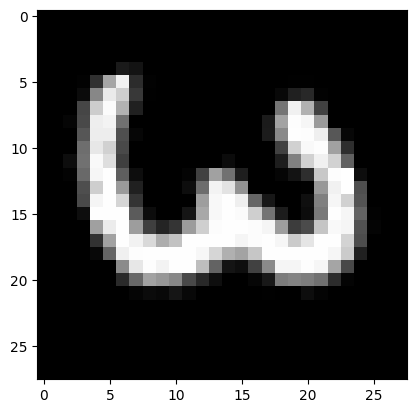

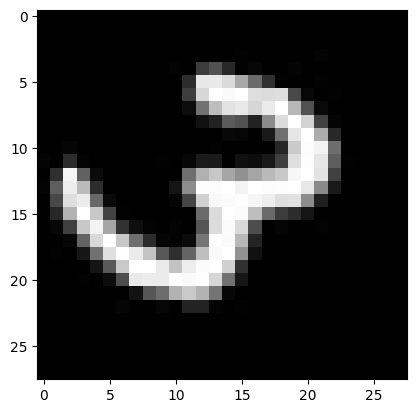

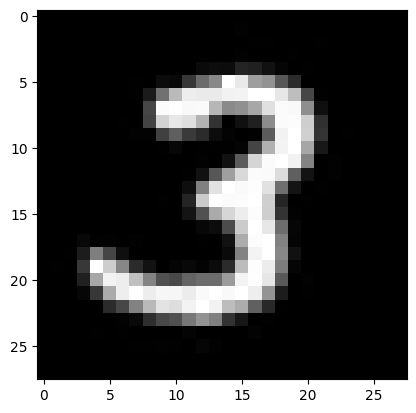

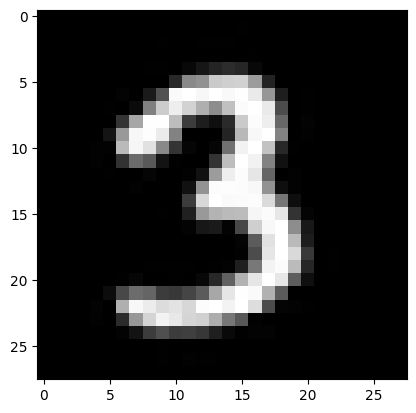

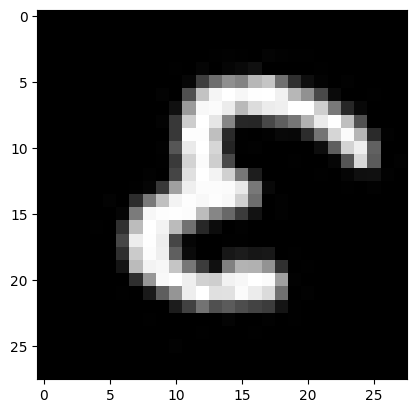

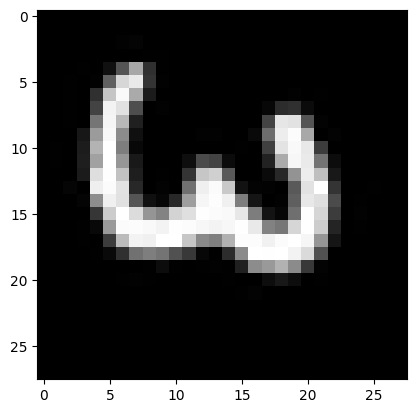

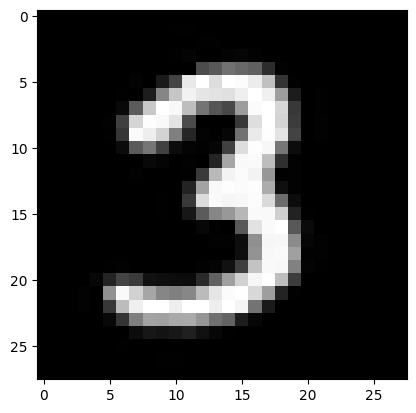

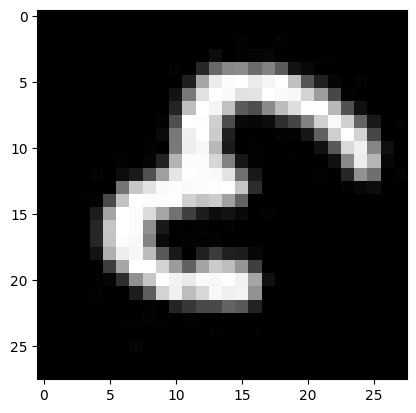

In [22]:
# use the sample method to resample an example from the validation set
# and plot the reconstruction

x_ = next(deterministic_data.start_input_pipeline(val_ds))['image'][0][14]

plt.imshow(x_, cmap='gray')
plt.show()
for i in range(10):
    x__ = aug_vae_model.apply({"params": params}, x_, train=False, method=aug_vae_model.resample, rngs={"sample": random.PRNGKey(i)})
    plt.imshow(rescale_for_imshow(x__), cmap='gray')
    plt.show()

    0/10000 [..............................] - ETA: 0s - elbo: -1149.2183 - iwlb: nan - ll: -1149.2183 - loss: 1149.2183 - z_kld: 0.0000e+00 - elbo_test: -943.7709 - iwlb_test: nan - ll_test: -943.6506 - loss_test: 943.7709 - z_kld_test: 0.0120

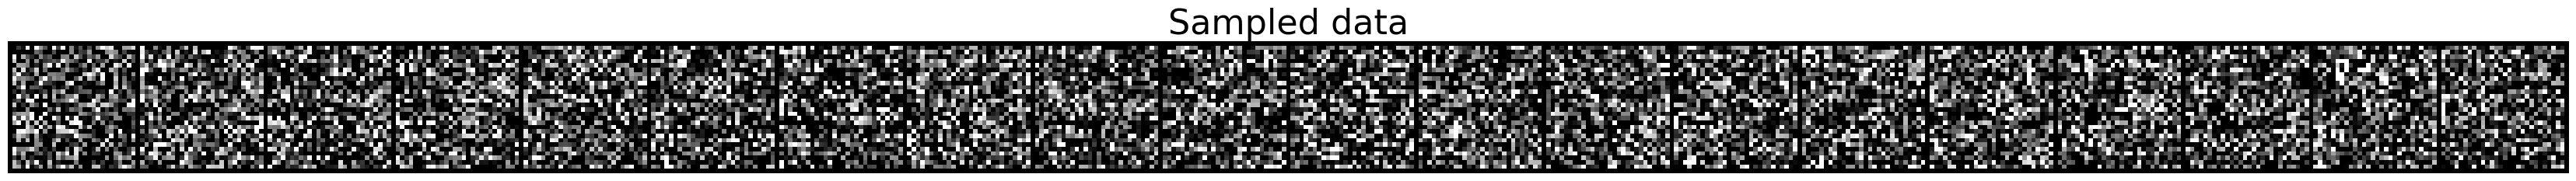

 1000/10000 [==>...........................] - ETA: 11:43 - elbo: -618.7560 - iwlb: nan - ll: -614.2293 - loss: 618.7560 - z_kld: 0.4619 - elbo_test: -603.0794 - iwlb_test: nan - ll_test: -598.0280 - loss_test: 603.0794 - z_kld_test: 0.516520 - ETA: 10:30:30 - elbo: -925.9570 - iwlb: nan - ll: -925.7986 - loss: 925.9570 - z_kld: 0.0158 - elbo_test: -943.7709 - iwlb_test: nan - ll_test: -943.6506 - loss_test: 943.7709 - z_kld_test: 0.012 - ETA: 8:11:33 - elbo: -915.4295 - iwlb: nan - ll: -915.2460 - loss: 915.4295 - z_kld: 0.0184 - elbo_test: -943.7709 - iwlb_test: nan - ll_test: -943.6506 - loss_test: 943.7709 - z_kld_test: 0.012 - ETA: 6:43:06 - elbo: -908.1108 - iwlb: nan - ll: -907.9188 - loss: 908.1108 - z_kld: 0.0192 - elbo_test: -943.7709 - iwlb_test: nan - ll_test: -943.6506 - loss_test: 943.7709 - z_kld_test: 0. - ETA: 4:56:59 - elbo: -894.0805 - iwlb: nan - ll: -893.8967 - loss: 894.0805 - z_kld: 0.0184 - elbo_test: -943.7709 - iwlb_test: nan - ll_test: -943.6506 - loss_test: 

 2000/10000 [=====>........................] - ETA: 8:46 - elbo: -329.9031 - iwlb: nan - ll: -323.5006 - loss: 329.9031 - z_kld: 0.6973 - elbo_test: -317.7766 - iwlb_test: nan - ll_test: -310.4922 - loss_test: 317.7766 - z_kld_test: 0.7969  ETA: 11:53 - elbo: -601.7969 - iwlb: nan - ll: -597.0250 - loss: 601.7969 - z_kld: 0.4881 - elbo_test: -603.0794 - iwlb_test: nan - ll_test: -598.0280 - loss_test: 603.0794 - z_kld_test: 0.51 - ETA: 11:52 - elbo: -601.5378 - iwlb: nan - ll: -596.7441 - loss: 601.5378 - z_kld: 0.4903 - elbo_test: -603.0794 - iwlb_test: nan - ll_test: -598.0280 - loss_test: 603.0794 - z_kld_test: 0.51 - ETA: 11:51 - elbo: -601.1235 - iwlb: nan - ll: -596.2818 - loss: 601.1235 - z_kld: 0.4952 - elbo_test: -603.0794 - iwlb_test: nan - ll_test: -598.0280 - loss_test: 603.0794 - z_kld_test: 0.51 - ETA: 11:50 - elbo: -600.6356 - iwlb: nan - ll: -595.8239 - loss: 600.6356 - z_kld: 0.4922 - elbo_test: -603.0794 - iwlb_test: nan - ll_test: -598.0280 - loss_test: 603.0794 - z_

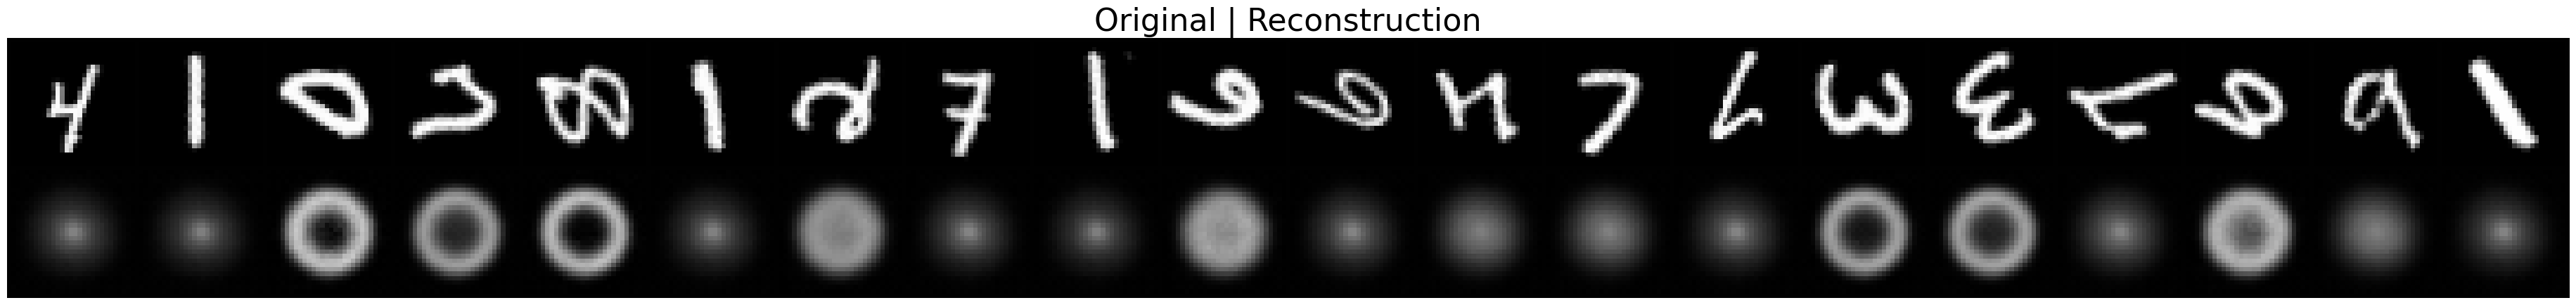

 3000/10000 [========>.....................] - ETA: 7:10 - elbo: -104.7566 - iwlb: nan - ll: -97.5950 - loss: 104.7566 - z_kld: 0.8732 - elbo_test: -96.4656 - iwlb_test: nan - ll_test: -87.8865 - loss_test: 96.4656 - z_kld_test: 1.0533   0- ETA: 8:51 - elbo: -316.2243 - iwlb: nan - ll: -309.6332 - loss: 316.2243 - z_kld: 0.7213 - elbo_test: -317.7766 - iwlb_test: nan - ll_test: -310.4922 - loss_test: 317.7766 - z_kld_test: 0.7 - ETA: 8:50 - elbo: -315.3800 - iwlb: nan - ll: -308.9200 - loss: 315.3800 - z_kld: 0.7071 - elbo_test: -317.7766 - iwlb_test: nan - ll_test: -310.4922 - loss_test: 317.7766 - z_kld_test: 0.7 - ETA: 8:49 - elbo: -314.7178 - iwlb: nan - ll: -308.1943 - loss: 314.7178 - z_kld: 0.7143 - elbo_test: -317.7766 - iwlb_test: nan - ll_test: -310.4922 - loss_test: 317.7766 - z_kld_test: 0.79 - ETA: 8:48 - elbo: -314.5306 - iwlb: nan - ll: -308.0126 - loss: 314.5306 - z_kld: 0.7138 - elbo_test: -317.7766 - iwlb_test: nan - ll_test: -310.4922 - loss_test: 317.7766 - z_kld_te

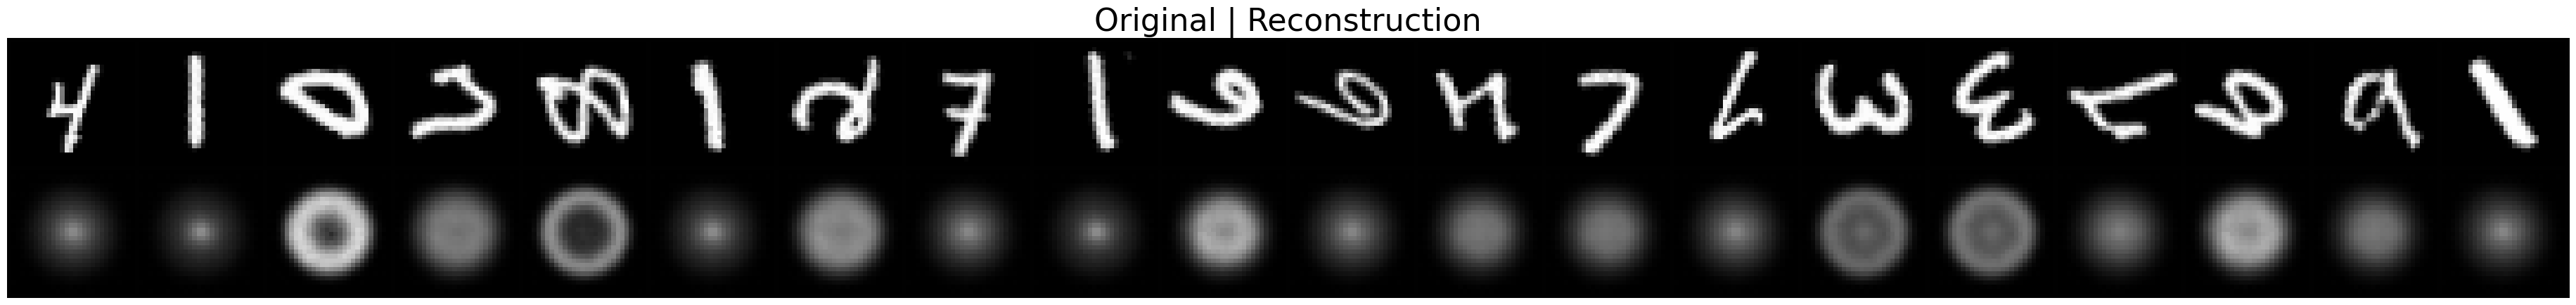

 4000/10000 [===========>..................] - ETA: 5:55 - elbo: 36.1599 - iwlb: nan - ll: 44.0558 - loss: -36.1599 - z_kld: 1.1349 - elbo_test: 39.8630 - iwlb_test: nan - ll_test: 48.2887 - loss_test: -39.8630 - z_kld_test: 1.2228  - ETA: 7:14 - elbo: -93.1747 - iwlb: nan - ll: -85.7657 - loss: 93.1747 - z_kld: 0.9104 - elbo_test: -96.4656 - iwlb_test: nan - ll_test: -87.8865 - loss_test: 96.4656 - z_kld_test: 1.053 - ETA: 7:14 - elbo: -93.3499 - iwlb: nan - ll: -86.0078 - loss: 93.3499 - z_kld: 0.9023 - elbo_test: -96.4656 - iwlb_test: nan - ll_test: -87.8865 - loss_test: 96.4656 - z_kld_test: 1.053 - ETA: 7:14 - elbo: -92.8875 - iwlb: nan - ll: -85.5975 - loss: 92.8875 - z_kld: 0.8960 - elbo_test: -96.4656 - iwlb_test: nan - ll_test: -87.8865 - loss_test: 96.4656 - z_kld_test: 1.053 - ETA: 7:13 - elbo: -92.8532 - iwlb: nan - ll: -85.5207 - loss: 92.8532 - z_kld: 0.9014 - elbo_test: -96.4656 - iwlb_test: nan - ll_test: -87.8865 - loss_test: 96.4656 - z_kld_test: 1.053 - ETA: 7:13 - e

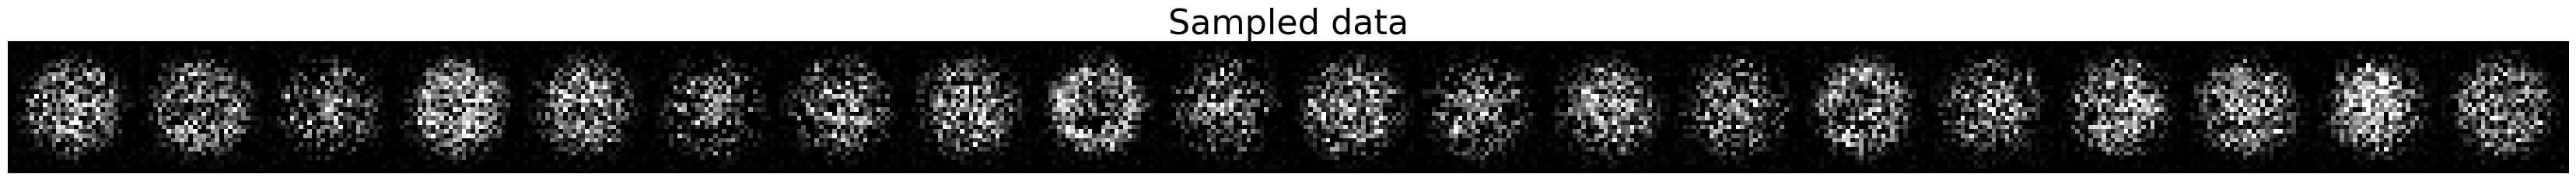

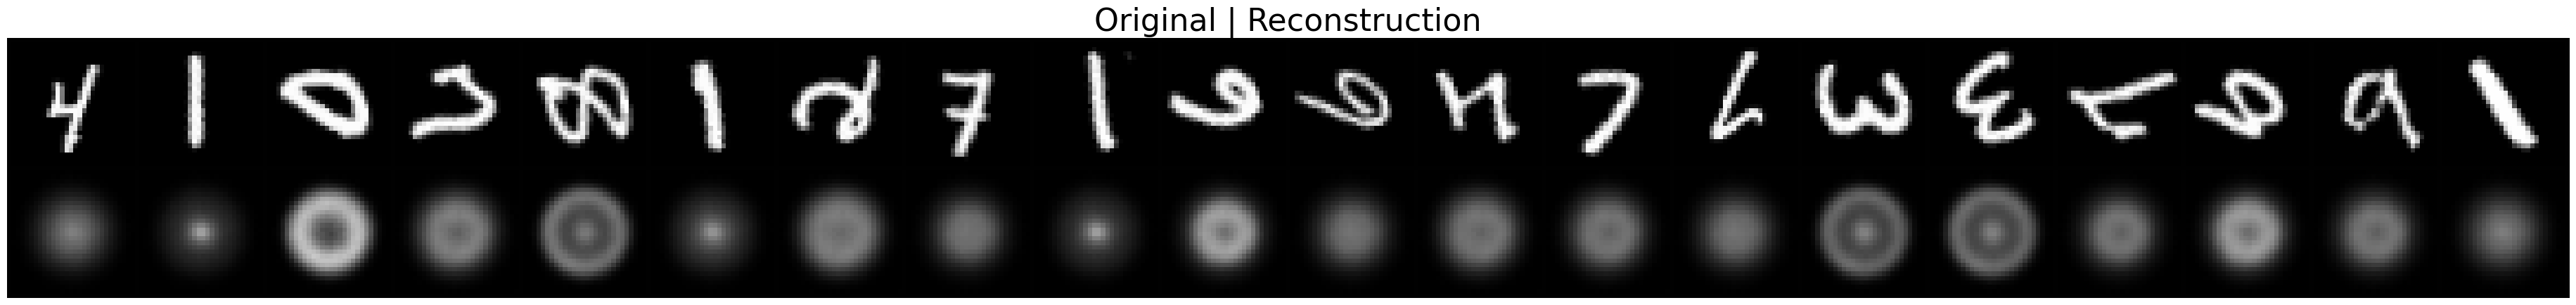

 5000/10000 [==============>...............] - ETA: 4:50 - elbo: 102.6546 - iwlb: nan - ll: 111.3531 - loss: -102.6546 - z_kld: 1.5614 - elbo_test: 100.0882 - iwlb_test: nan - ll_test: 109.5252 - loss_test: -100.0882 - z_kld_test: 1.7158 5:57 - elbo: 41.7759 - iwlb: nan - ll: 49.6948 - loss: -41.7759 - z_kld: 1.1499 - elbo_test: 39.8630 - iwlb_test: nan - ll_test: 48.2887 - loss_test: -39.8630 - z_kld_test: 1.2 - ETA: 5:56 - elbo: 41.2802 - iwlb: nan - ll: 49.2315 - loss: -41.2802 - z_kld: 1.1553 - elbo_test: 39.8630 - iwlb_test: nan - ll_test: 48.2887 - loss_test: -39.8630 - z_kld_test: 1.22 - ETA: 5:56 - elbo: 40.4704 - iwlb: nan - ll: 48.4159 - loss: -40.4704 - z_kld: 1.1549 - elbo_test: 39.8630 - iwlb_test: nan - ll_test: 48.2887 - loss_test: -39.8630 - z_kld_test: 1.222 - ETA: 5:56 - elbo: 40.6055 - iwlb: nan - ll: 48.6067 - loss: -40.6055 - z_kld: 1.1632 - elbo_test: 39.8630 - iwlb_test: nan - ll_test: 48.2887 - loss_test: -39.8630 - z_kld_test: 1.22 - ETA: 5:55 - elbo: 40.9211 -

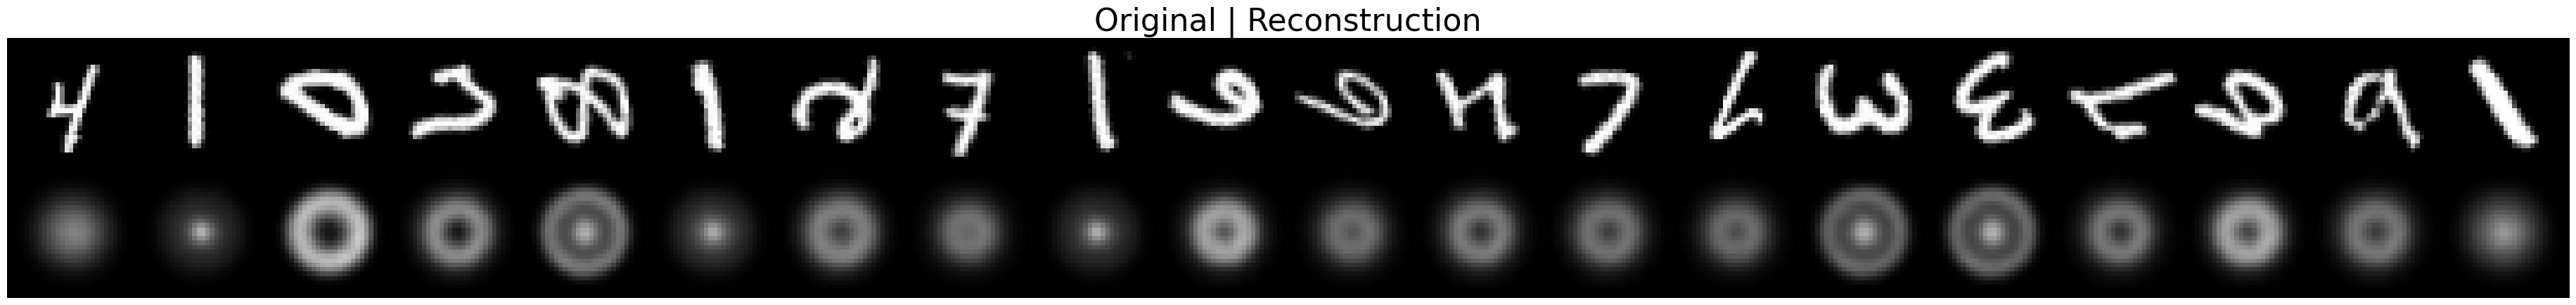

 6000/10000 [=================>............] - ETA: 3:48 - elbo: 121.7993 - iwlb: nan - ll: 130.8318 - loss: -121.7993 - z_kld: 2.1623 - elbo_test: 118.7899 - iwlb_test: nan - ll_test: 128.7269 - loss_test: -118.7899 - z_kld_test: 2.4181- ETA: 4:50 - elbo: 107.9394 - iwlb: nan - ll: 116.4745 - loss: -107.9394 - z_kld: 1.5550 - elbo_test: 100.0882 - iwlb_test: nan - ll_test: 109.5252 - loss_test: -100.0882 - z_kld_test: 1.7 - ETA: 4:49 - elbo: 106.5671 - iwlb: nan - ll: 115.2580 - loss: -106.5671 - z_kld: 1.5847 - elbo_test: 100.0882 - iwlb_test: nan - ll_test: 109.5252 - loss_test: -100.0882 - z_kld_test: 1. - ETA: 4:49 - elbo: 105.8426 - iwlb: nan - ll: 114.5208 - loss: -105.8426 - z_kld: 1.5840 - elbo_test: 100.0882 - iwlb_test: nan - ll_test: 109.5252 - loss_test: -100.0882 - z_kld_test: 1.715 - ETA: 4:49 - elbo: 104.2327 - iwlb: nan - ll: 112.9094 - loss: -104.2327 - z_kld: 1.5842 - elbo_test: 100.0882 - iwlb_test: nan - ll_test: 109.5252 - loss_test: -100.0882 - z_kld_test: 1.71 -

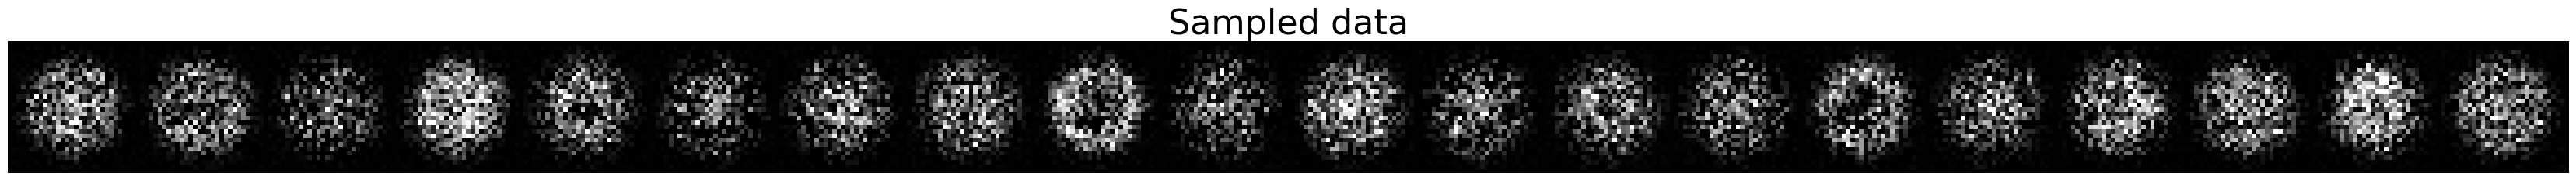

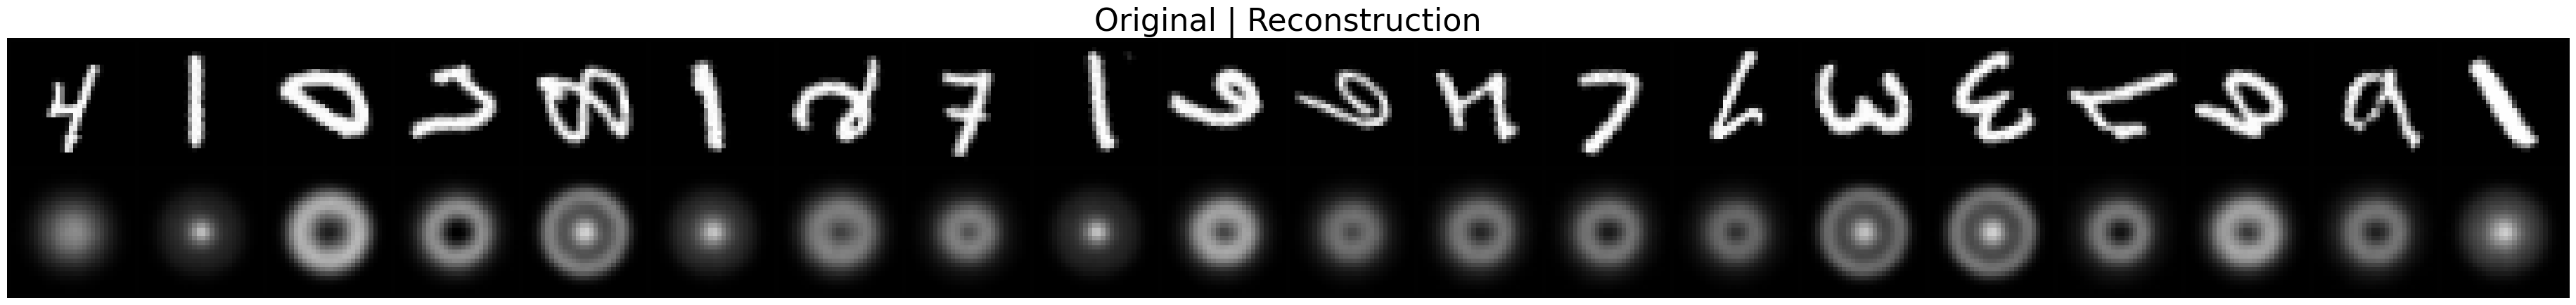

 7000/10000 [====================>.........] - ETA: 2:50 - elbo: 136.0326 - iwlb: nan - ll: 144.0683 - loss: -136.0326 - z_kld: 2.7588 - elbo_test: 124.9573 - iwlb_test: nan - ll_test: 133.3220 - loss_test: -124.9573 - z_kld_test: 2.9299- ETA: 3:49 - elbo: 132.3039 - iwlb: nan - ll: 141.3193 - loss: -132.3039 - z_kld: 2.1960 - elbo_test: 118.7899 - iwlb_test: nan - ll_test: 128.7269 - loss_test: -118.7899 - z_kld_test: 2.4 - ETA: 3:48 - elbo: 145.1282 - iwlb: nan - ll: 154.0978 - loss: -145.1282 - z_kld: 2.1870 - elbo_test: 118.7899 - iwlb_test: nan - ll_test: 128.7269 - loss_test: -118.7899 - z_kld_test: 2. - ETA: 3:48 - elbo: 134.5282 - iwlb: nan - ll: 143.4467 - loss: -134.5282 - z_kld: 2.1770 - elbo_test: 118.7899 - iwlb_test: nan - ll_test: 128.7269 - loss_test: -118.7899 - z_kld_test: 2.4 - ETA: 3:48 - elbo: 134.6312 - iwlb: nan - ll: 143.5405 - loss: -134.6312 - z_kld: 2.1769 - elbo_test: 118.7899 - iwlb_test: nan - ll_test: 128.7269 - loss_test: -118.7899 - z_kld_test: 2.4 - ET

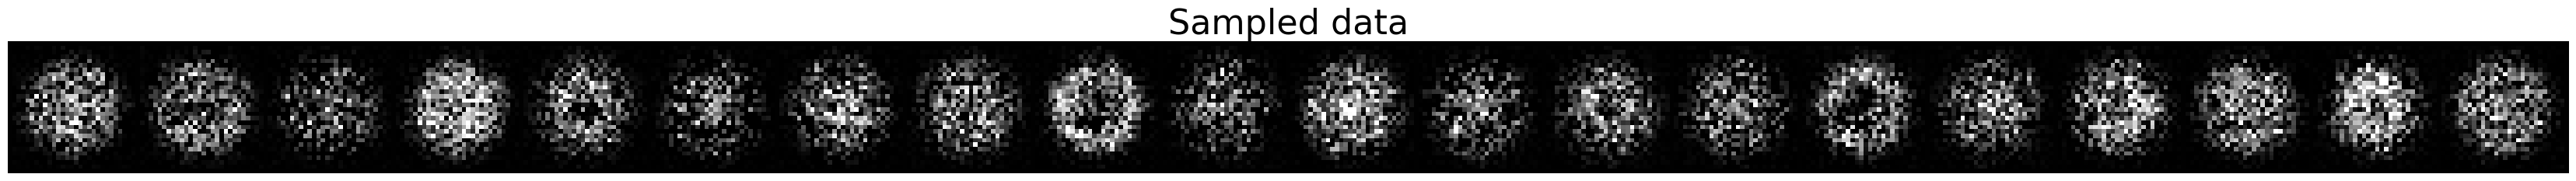

 8000/10000 [=======================>......] - ETA: 1:52 - elbo: 139.6031 - iwlb: nan - ll: 146.2587 - loss: -139.6031 - z_kld: 3.4998 - elbo_test: 129.1978 - iwlb_test: nan - ll_test: 136.1712 - loss_test: -129.1978 - z_kld_test: 3.7503- ETA: 2:50 - elbo: 109.6078 - iwlb: nan - ll: 117.4984 - loss: -109.6078 - z_kld: 2.7728 - elbo_test: 124.9573 - iwlb_test: nan - ll_test: 133.3220 - loss_test: -124.9573 - z_kld_test: 2.929 - ETA: 2:49 - elbo: 112.3332 - iwlb: nan - ll: 120.2420 - loss: -112.3332 - z_kld: 2.7803 - elbo_test: 124.9573 - iwlb_test: nan - ll_test: 133.3220 - loss_test: -124.9573 - z_kld_test: 2.929 - ETA: 2:49 - elbo: 116.3653 - iwlb: nan - ll: 124.2881 - loss: -116.3653 - z_kld: 2.7863 - elbo_test: 124.9573 - iwlb_test: nan - ll_test: 133.3220 - loss_test: -124.9573 - z_kld_test: 2.929 - ETA: 2:49 - elbo: 115.3808 - iwlb: nan - ll: 123.3121 - loss: -115.3808 - z_kld: 2.7904 - elbo_test: 124.9573 - iwlb_test: nan - ll_test: 133.3220 - loss_test: -124.9573 - z_kld_test: 2

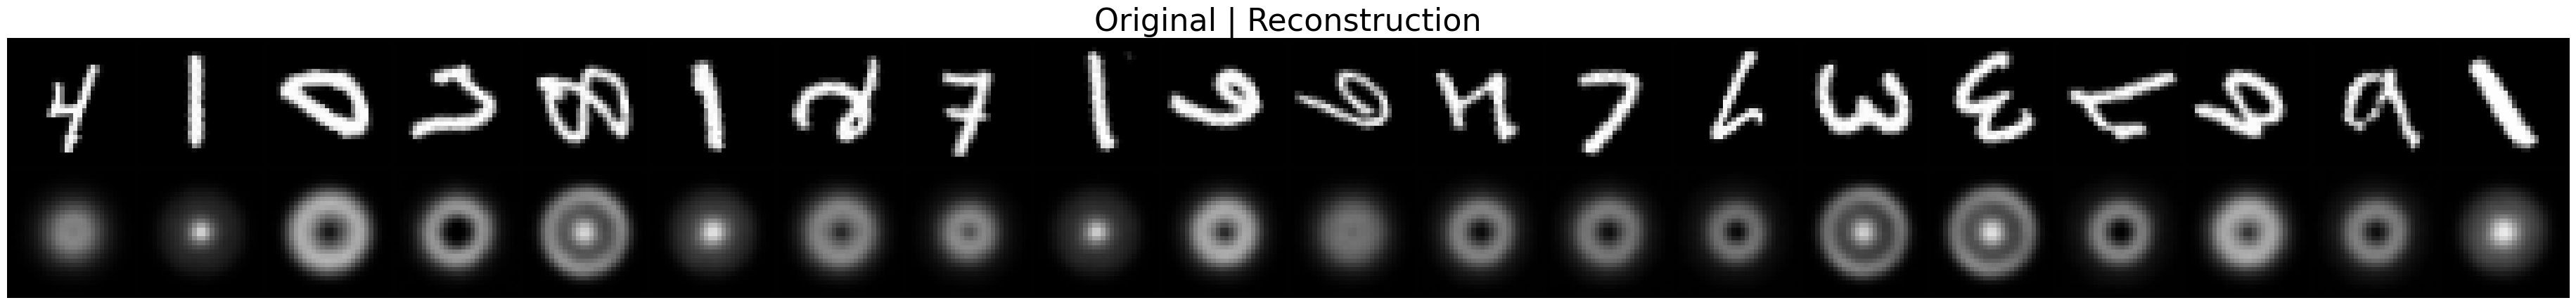

 9000/10000 [==========================>...] - ETA: 56s - elbo: 143.1958 - iwlb: nan - ll: 149.1076 - loss: -143.1958 - z_kld: 4.7561 - elbo_test: 130.1840 - iwlb_test: nan - ll_test: 136.1655 - loss_test: -130.1840 - z_kld_test: 4.90198- ETA: 1:52 - elbo: 160.8836 - iwlb: nan - ll: 167.3622 - loss: -160.8836 - z_kld: 3.4888 - elbo_test: 129.1978 - iwlb_test: nan - ll_test: 136.1712 - loss_test: -129.1978 - z_kld_test: 3.75 - ETA: 1:52 - elbo: 157.6212 - iwlb: nan - ll: 164.1237 - loss: -157.6212 - z_kld: 3.5049 - elbo_test: 129.1978 - iwlb_test: nan - ll_test: 136.1712 - loss_test: -129.1978 - z_kld_test: 3.750 - ETA: 1:52 - elbo: 159.6022 - iwlb: nan - ll: 166.1046 - loss: -159.6022 - z_kld: 3.5063 - elbo_test: 129.1978 - iwlb_test: nan - ll_test: 136.1712 - loss_test: -129.1978 - z_kld_test: 3.75 - ETA: 1:52 - elbo: 159.4839 - iwlb: nan - ll: 165.9997 - loss: -159.4839 - z_kld: 3.5168 - elbo_test: 129.1978 - iwlb_test: nan - ll_test: 136.1712 - loss_test: -129.1978 - z_kld_test: 3.7

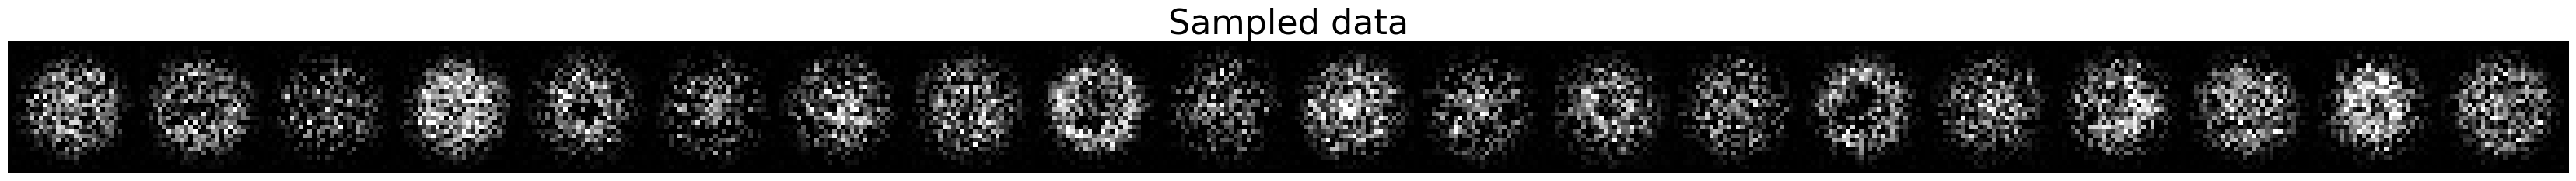

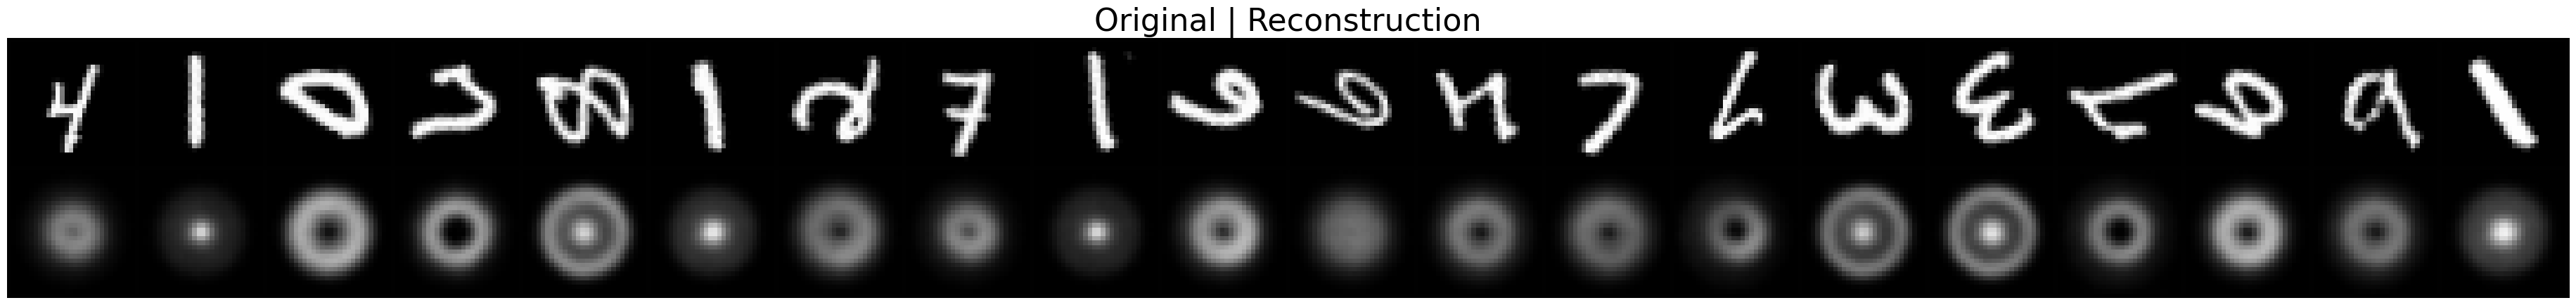

10000/10000 [==============================] - 558s 56ms/step - elbo: 146.3899 - iwlb: nan - ll: 151.7965 - loss: -146.3899 - z_kld: 5.4026 - elbo_test: 129.7743 - iwlb_test: nan - ll_test: 135.5078 - loss_test: -129.7743 - z_kld_test: 5.733455s - elbo: 120.4550 - iwlb: nan - ll: 126.4128 - loss: -120.4550 - z_kld: 4.8878 - elbo_test: 130.1840 - iwlb_test: nan - ll_test: 136.1655 - loss_test: -130.1840 - z_kld_test:  - ETA: 55s - elbo: 126.6476 - iwlb: nan - ll: 132.6056 - loss: -126.6476 - z_kld: 4.8932 - elbo_test: 130.1840 - iwlb_test: nan - ll_test: 136.1655 - loss_test: -130.1840 - z_kld_test:  - ETA: 55s - elbo: 127.6580 - iwlb: nan - ll: 133.5826 - loss: -127.6580 - z_kld: 4.8708 - elbo_test: 130.1840 - iwlb_test: nan - ll_test: 136.1655 - loss_test: -130.1840 - z_kld_test - ETA: 54s - elbo: 124.8364 - iwlb: nan - ll: 130.7700 - loss: -124.8364 - z_kld: 4.8852 - elbo_test: 130.1840 - iwlb_test: nan - ll_test: 136.1655 - loss_test: -130.1840 - z_kld_test:  - ETA: 54s - elbo: 131.

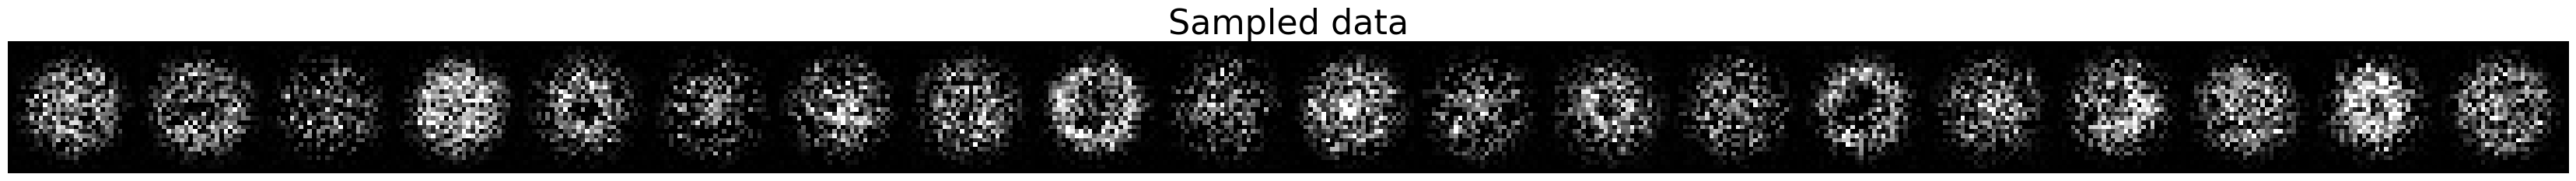

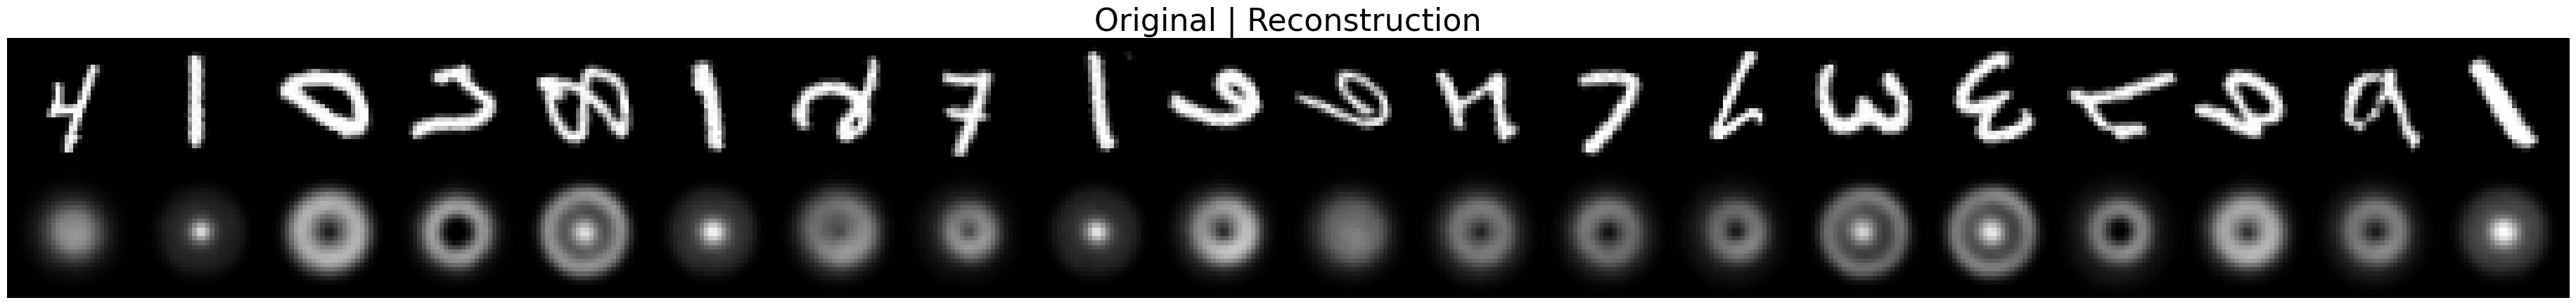

In [23]:
final_aug_vae_state, history, _ = ciclo.train_loop(
    aug_vae_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.every(int(vae_config.steps * vae_config.plot_freq)): [
            sampling_plot,
            reconstruction_plot,
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            eval_step,
        ],
        # ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(vae_config.steps * vae_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=vae_config.steps),
    ],
    stop=vae_config.steps + 1,
)

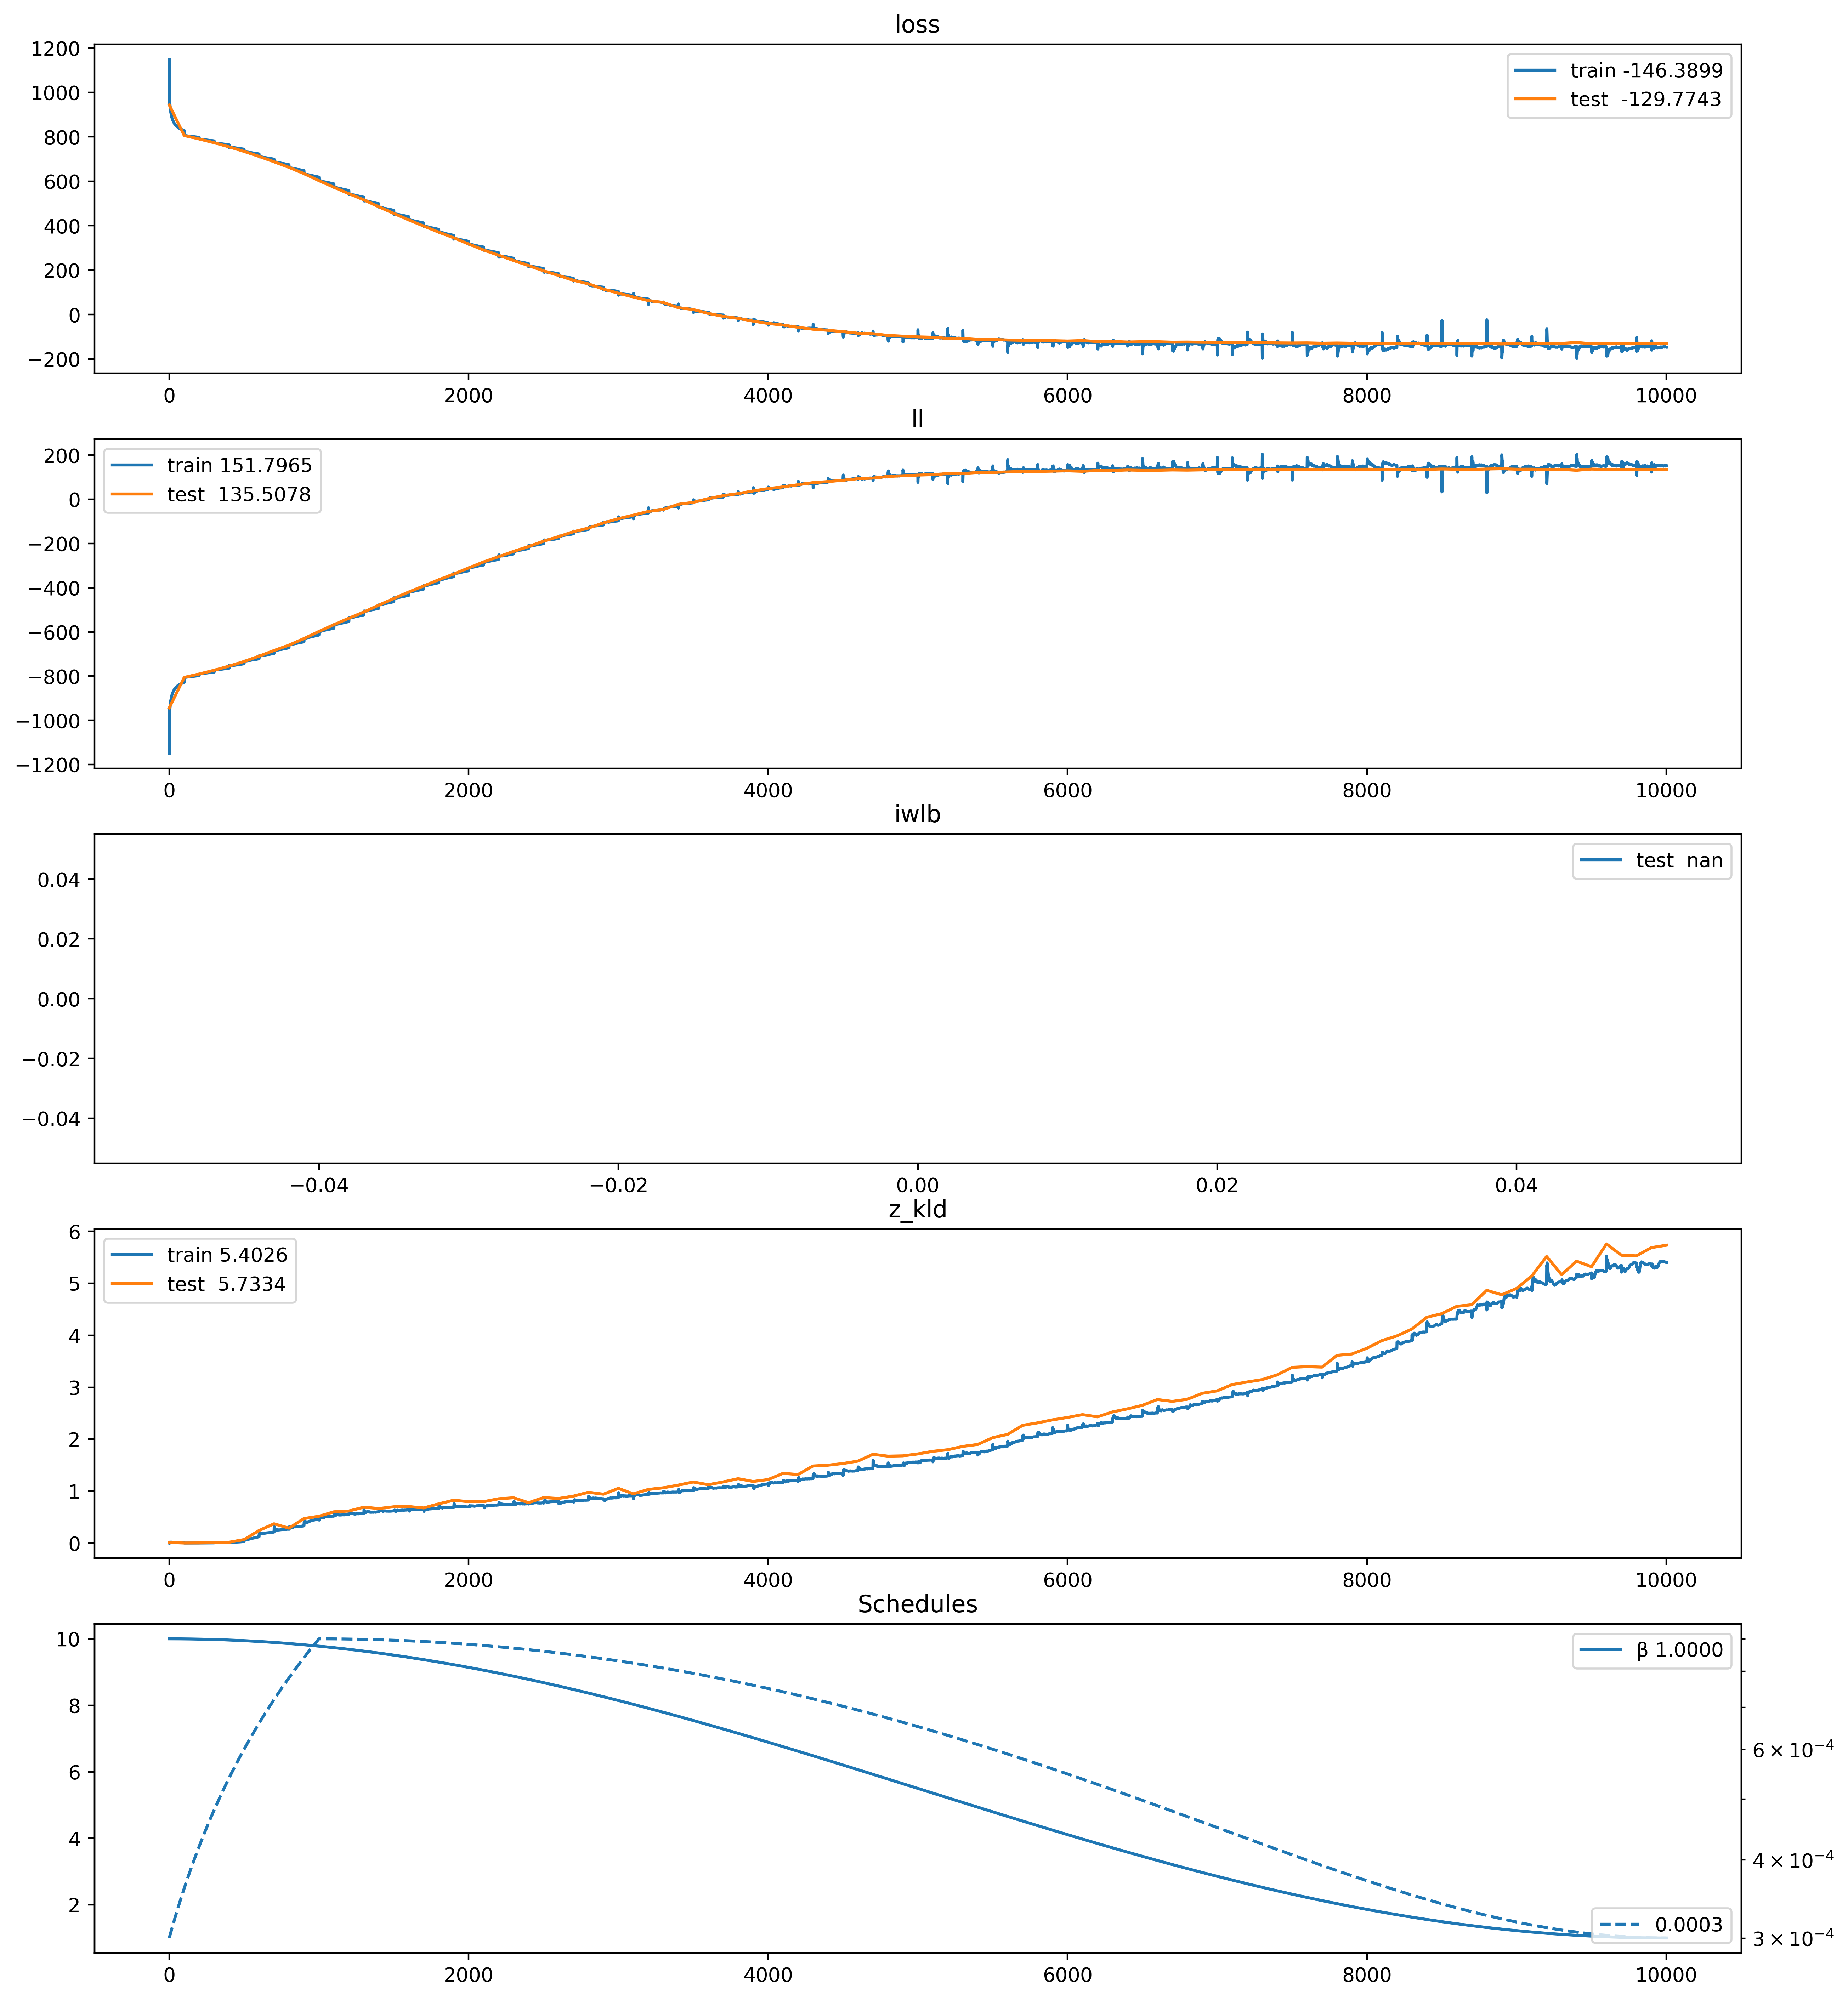

In [24]:
# plot the training history
steps, loss, elbo, ll, z_kld, lr, β = history.collect(
    "steps", "loss", "elbo", "ll", "z_kld", "lr", "β"
)
steps_test, loss_test, elbo_test, ll_test, z_kld_test, iwlb_test = history.collect(
    "steps", "loss_test", "elbo_test", "ll_test", "z_kld_test", "iwlb_test"
)

n_plots = 5
fig, axs = plt.subplots(n_plots, 1, figsize=(15, 3.5 * n_plots), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, ll, label=f"train {ll[-1]:.4f}")
axs[1].plot(steps_test, ll_test, label=f"test  {ll_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps_test, iwlb_test, label=f"test  {iwlb_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, z_kld, label=f"train {z_kld[-1]:.4f}")
axs[3].plot(steps_test, z_kld_test, label=f"test  {z_kld_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("z_kld")

axs[4].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[4].legend()
axs[4].set_title("Schedules")

ax4_twin = axs[4].twinx()
ax4_twin.plot(steps, lr, "--", label=f"{lr[-1]:.4f}")
ax4_twin.legend(loc="lower right")
ax4_twin.set_yscale("log")

plt.show()